In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
image_dir = Path('../input/plantvillage-grape')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()


Filepath  \
0  ../input/plantvillage-grape/Grape/Grape___Blac...   
1  ../input/plantvillage-grape/Grape/Grape___Blac...   
2  ../input/plantvillage-grape/Grape/Grape___Esca...   
3  ../input/plantvillage-grape/grape/Grape/Grape_...   
4  ../input/plantvillage-grape/grape/Grape/Grape_...   

                          Label  
0             Grape___Black_rot  
1             Grape___Black_rot  
2  Grape___Esca_(Black_Measles)  
3  Grape___Esca_(Black_Measles)  
4  Grape___Esca_(Black_Measles)

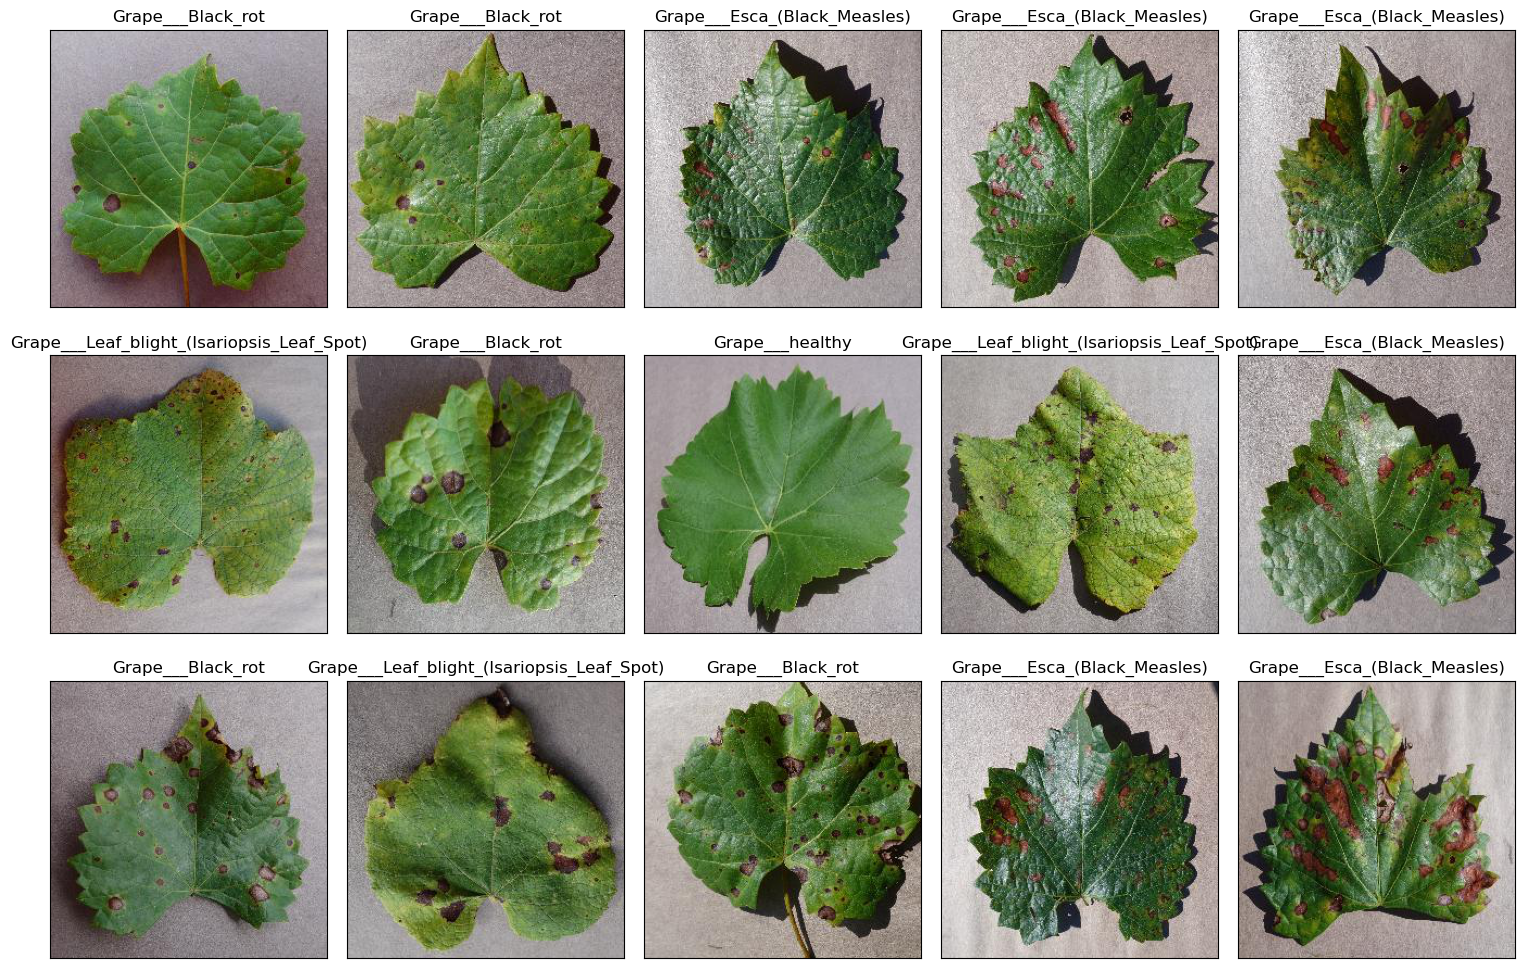

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()


In [5]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [6]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [7]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

# Create the generators
train_generator,test_generator,train_images,val_images,test_images = create_gen()


Found 6580 validated image filenames belonging to 4 classes.
Found 731 validated image filenames belonging to 4 classes.
Found 813 validated image filenames belonging to 4 classes.


In [8]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
206/206 [==============================] - 164s 780ms/step - loss: 0.1133 - accuracy: 0.9594 - val_loss: 0.0412 - val_accuracy: 0.9850
Epoch 2/10
206/206 [==============================] - 157s 762ms/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.0282 - val_accuracy: 0.9877
Epoch 3/10
206/206 [==============================] - 159s 771ms/step - loss: 0.0230 - accuracy: 0.9924 - val_loss: 0.0186 - val_accuracy: 0.9932
Epoch 4/10
206/206 [==============================] - 161s 781ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0088 - val_accuracy: 0.9932
Epoch 5/10
206/206 [==============================] - 158s 769ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0075 - val_accuracy: 0.9973
Epoch 6/10
206/206 [==============================] - 156s 757ms/step - loss: 0.0048 - accuracy: 0.9977 - val_loss: 0.0058 - val_accuracy: 0.9986
Epoch 7/10
206/206 [==============================] - 159s 770ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0040 -

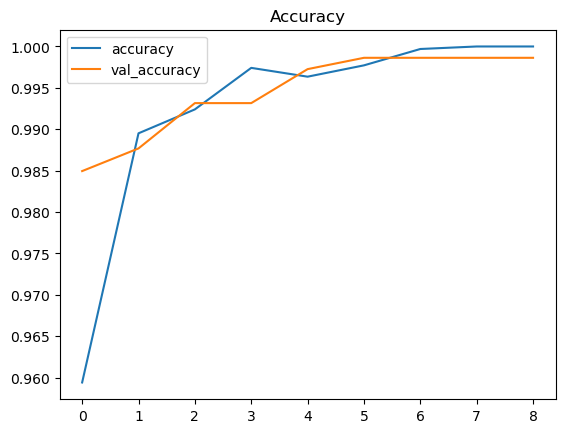

In [9]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


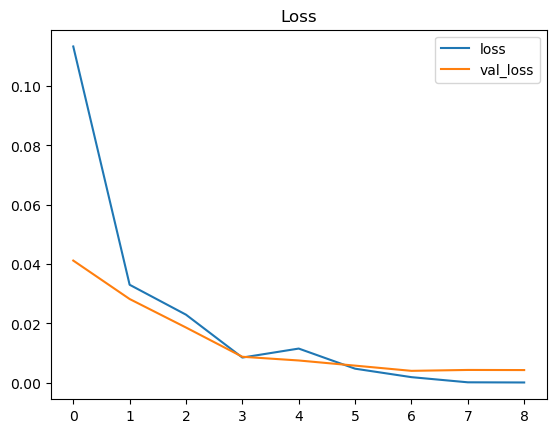

In [10]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()


In [11]:
results = model.evaluate(test_images, verbose=0)


In [12]:
printmd("  Test Loss: {:.5f}".format(results[0]))
printmd(" Accuracy on the test set: {:.2f}%".format(results[1] * 100))

  Test Loss: 0.00376

 Accuracy on the test set: 99.88%

In [13]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

26/26 [==============================] - 19s 677ms/step
The first 5 predictions: ['Grape___Esca_(Black_Measles)', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Esca_(Black_Measles)', 'Grape___Black_rot']


In [14]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                            precision    recall  f1-score   support

                         Grape___Black_rot       1.00      1.00      1.00       227
              Grape___Esca_(Black_Measles)       1.00      1.00      1.00       293
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00       209
                           Grape___healthy       1.00      1.00      1.00        84

                                  accuracy                           1.00       813
                                 macro avg       1.00      1.00      1.00       813
                              weighted avg       1.00      1.00      1.00       813



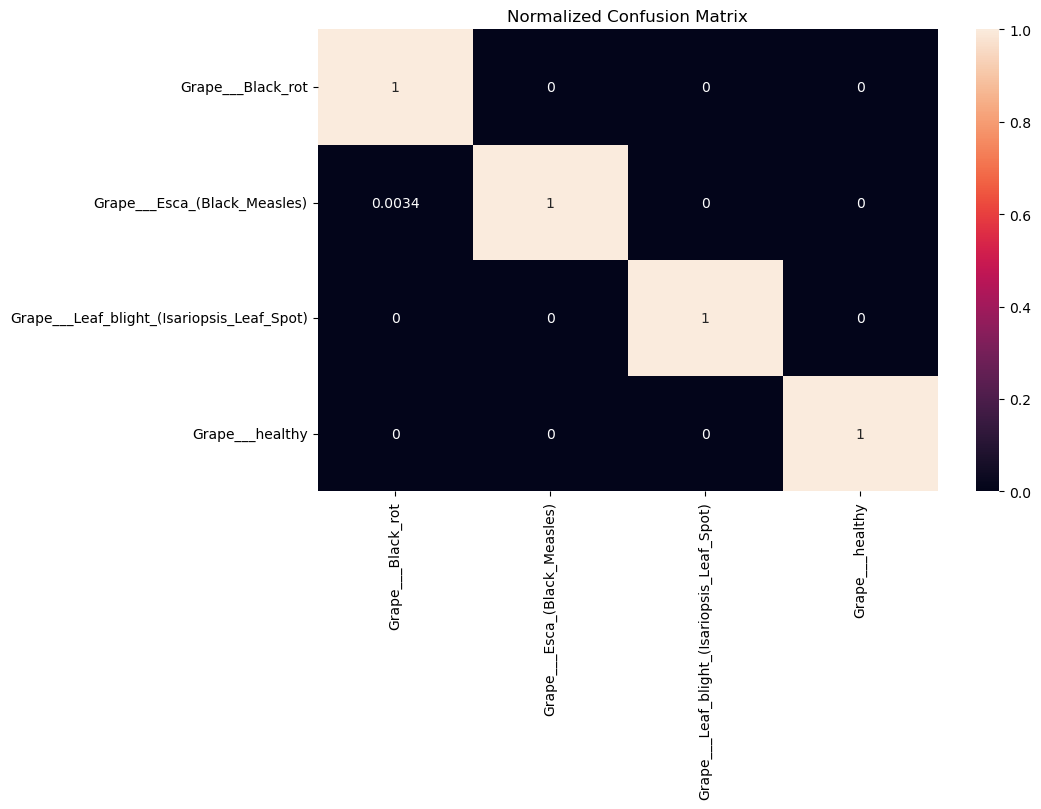

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

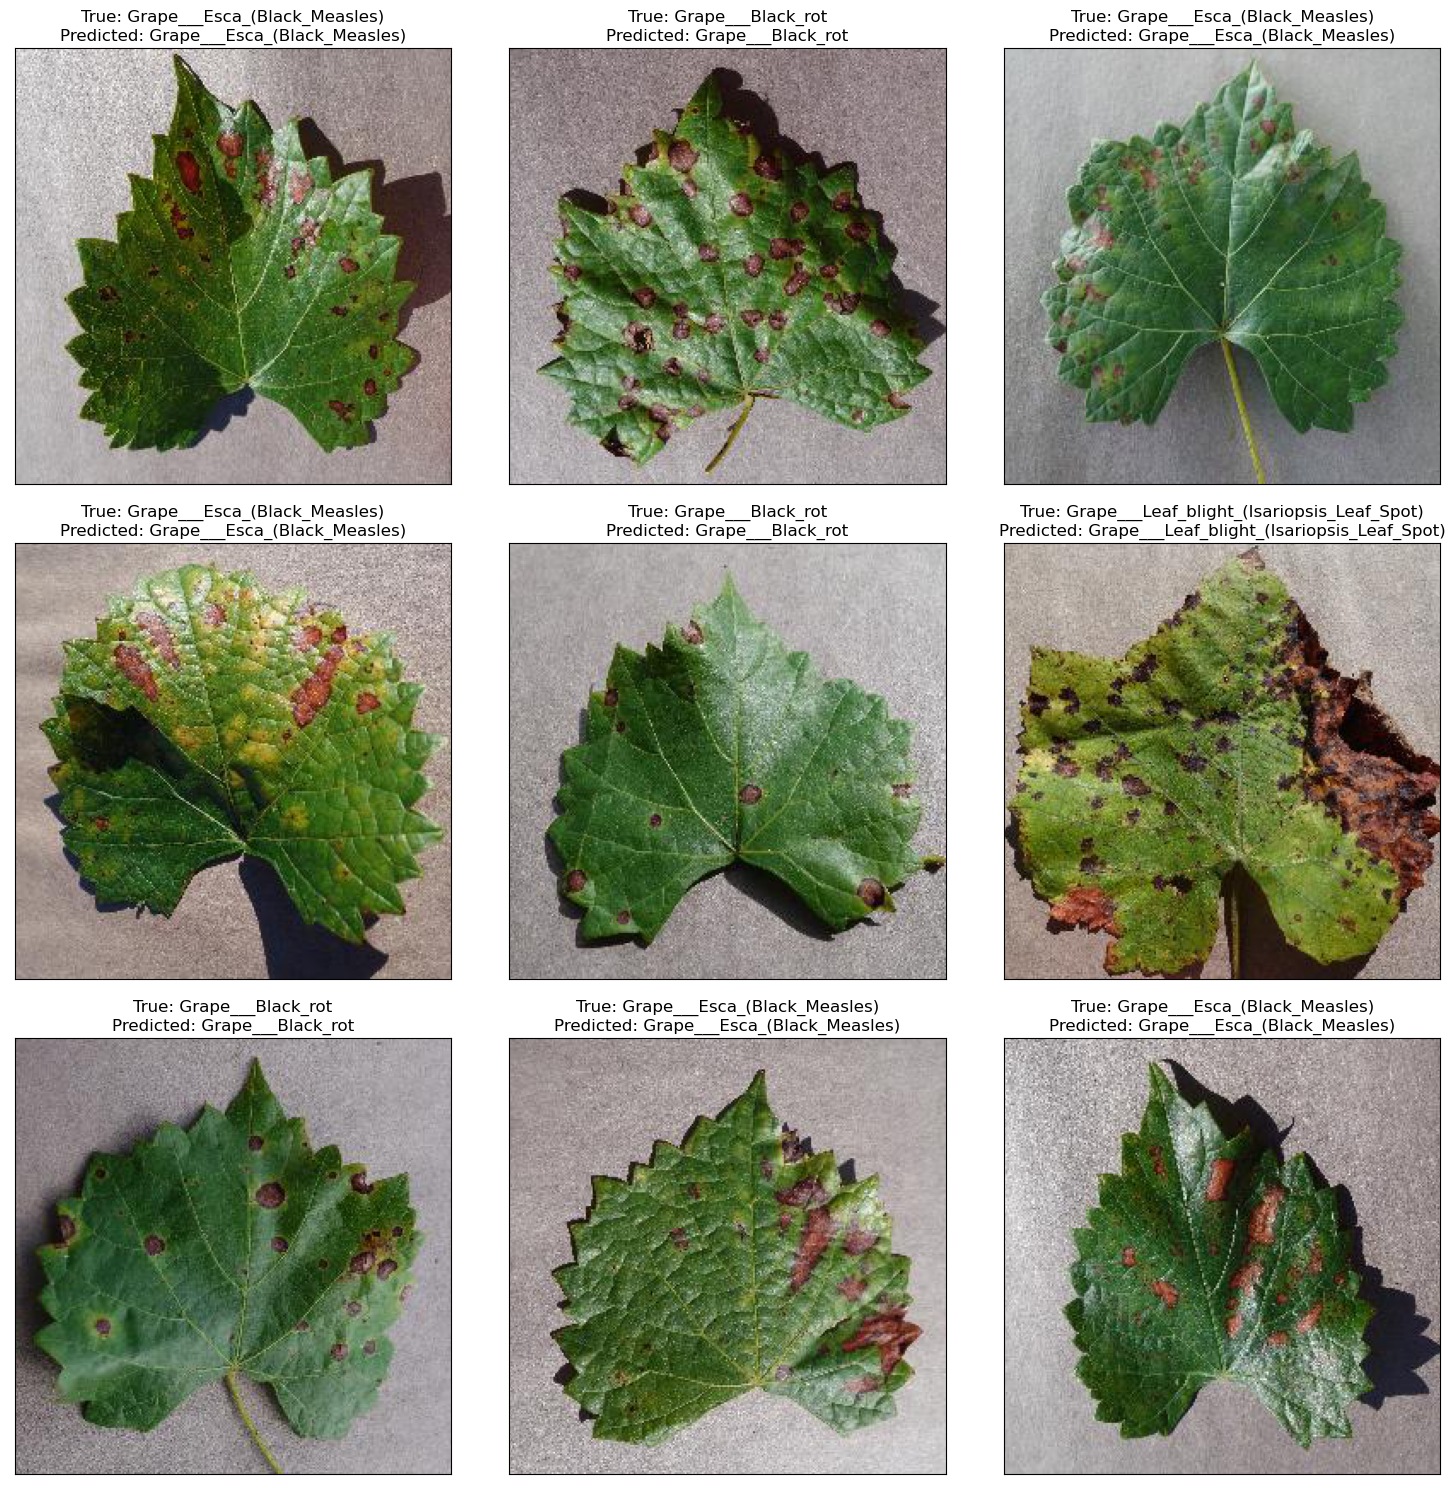

In [16]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()